# Define Baseline with CNN and GRU Models

## Define pre-processing functions to extract Mel Spectrograms and MFCC-s

In [52]:
%pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [53]:
import math
import wave
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pylab
import pandas as pd
import scipy.io.wavfile as wav
import scipy.signal as sig
import skimage.measure
import time
import os
from scipy.io.wavfile import read
from sklearn import preprocessing
from scipy.fftpack import dct  # Discrete Cosine Transform

In [54]:
# Constants
SPECTR_DUR = 128
NUMCEP = 40  # Number of coefficients to extract
MFCC_DUR = 50
MFCC_STEP = 25

In [55]:
def generate_spectrogram(wav_file, view=False):
    MAX_SPECTRG_LENGTH = 999  # 8 sec
    MAX_SPECTRG_TIME_LENGTH_POOLED = SPECTR_DUR
    MAX_SPECTRG_FREQ_LENGTH_POOLED = SPECTR_DUR

    def get_wav_info(wav_file):
        wav = wave.open(wav_file, 'r')
        frames = wav.readframes(-1)
        sound_info = np.fromstring(frames, dtype=np.uint16)
        frame_rate = wav.getframerate()
        wav.close()
        return sound_info, frame_rate

    frame_rate, sound_info = wav.read(wav_file)
    spec, freqs, times, axes = pylab.specgram(sound_info, Fs=frame_rate)
    times = times[:MAX_SPECTRG_LENGTH]
    spec = spec[:, :MAX_SPECTRG_LENGTH]
    spec_log = np.log(spec)
    spec_pooled = skimage.measure.block_reduce(spec_log, (1, 8), np.mean)
    spec_cropped = spec_pooled[:MAX_SPECTRG_FREQ_LENGTH_POOLED, :MAX_SPECTRG_TIME_LENGTH_POOLED]
    spectrogram = np.zeros((MAX_SPECTRG_FREQ_LENGTH_POOLED, MAX_SPECTRG_TIME_LENGTH_POOLED))
    spectrogram[:, :spec_cropped.shape[1]] = spec_cropped

    if view:
        plt.imshow(spec_cropped, cmap='hot', interpolation='nearest')
        plt.show()
    return spectrogram


def generate_mel_spectr(file_audio, view=False):
    y, sr = librosa.load(file_audio, sr=16000)
    mspectr = librosa.feature.melspectrogram(
                            y=y, 
                            sr=sr, 
                            n_fft=2048, 
                            hop_length=int(0.01 * sr),
                            win_length=int(0.025 * sr),
                            window='hann')
    log_mspectr = librosa.power_to_db(mspectr)

    if view:
        plt.imshow(log_mspectr, cmap='hot', interpolation='nearest')
        plt.show()
    return log_mspectr


def generate_mfcc(file_audio, view=False):
    rate, audio_input = read(file_audio)
    scaler = preprocessing.StandardScaler()
    standard_X = np.hstack(scaler.fit_transform(np.vstack(audio_input)))
    mfcc = librosa.feature.mfcc(
                            y=standard_X,
                            sr=rate,    # fs
                            n_mfcc=NUMCEP, 
                            n_fft=2048, 
                            lifter=2 * NUMCEP)

    if view:
        fs, sig = wav.read(file_audio)
        plt.figure(figsize=(20, 5))
        plt.title('MFCC')
        plt.imshow(mfcc.T, aspect='auto', extent=[0, len(sig) / fs, 0, 10])
        plt.ylabel('Coefficients', fontsize=18)
        plt.xlabel('Time [sec]', fontsize=18)
        plt.tight_layout()
        plt.show()
    return mfcc

## Pre-process AIBO and IEMOCAP

In [56]:
import os
import pickle

LOCAL_DIR = './data/'
save_path = LOCAL_DIR + 'mfcc_msp/'

os.makedirs(save_path, exist_ok=True)

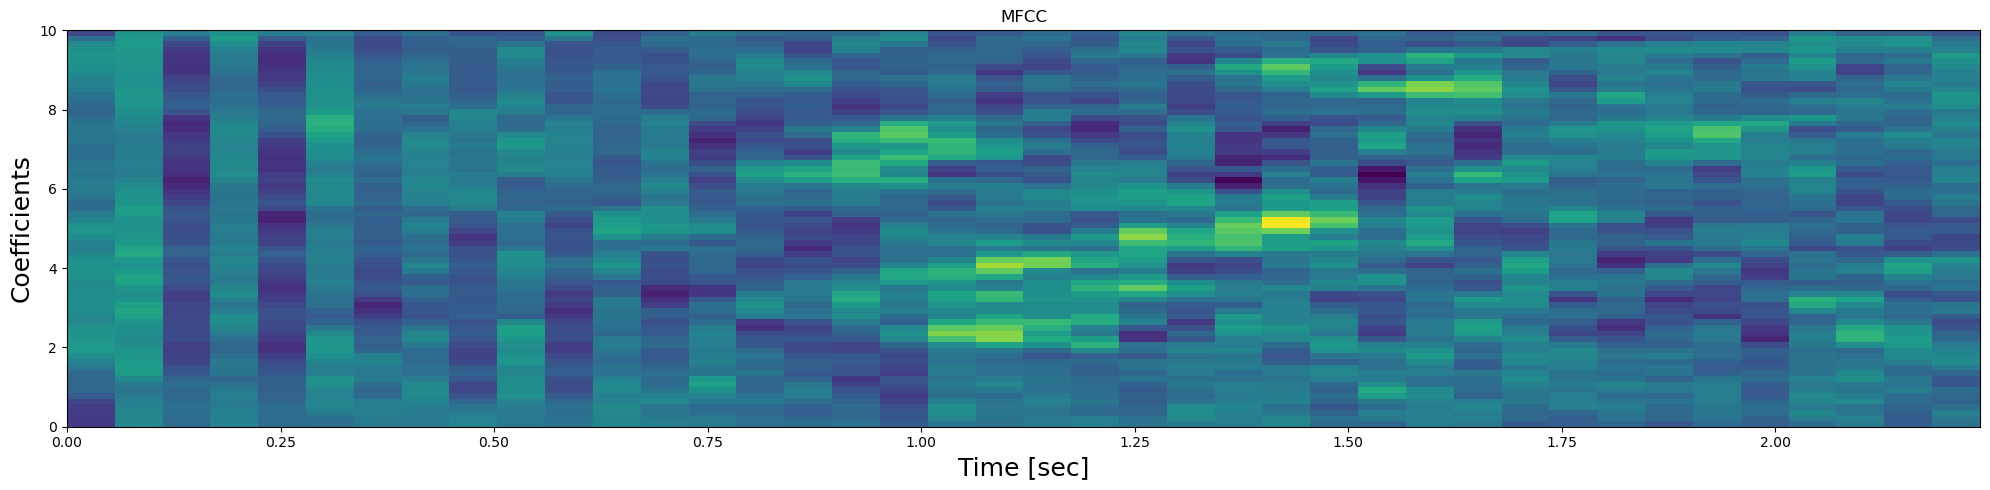

In [57]:
test_mfcc = generate_mfcc(os.path.join(LOCAL_DIR, "IEMOCAP/Session5/Ses05M_script03_2_M043.wav"), view=True)

In [58]:
test_mfcc.shape

(40, 70)

In [59]:
ICP_CLASS_TO_ID = {"neu": 0, "hap": 1, "sad": 2, "fru": 3, "ang": 4}
ICP_ID_TO_CLASS = {v: k for k, v in ICP_CLASS_TO_ID.items()}

AIBO_CLASS_TO_ID = {'A': 0, 'E': 1, 'N': 2, 'P': 3, 'R': 4}
AIBO_ID_TO_CLASS = {v: k for k, v in AIBO_CLASS_TO_ID.items()}

In [60]:
# datasets from .pkl
with open(os.path.join(LOCAL_DIR, 'adults.pkl'), 'rb') as f:
    iemocap_df = pickle.load(f)

with open(os.path.join(LOCAL_DIR, 'children.pkl'), 'rb') as f:
    aibo_df = pickle.load(f)

In [61]:
iemocap_df

,filename,emotion,gender,path
0,Ses01F_impro01_F000,neu,1,IEMOCAP/Session1/Ses01F_impro01_F000.wav
1,Ses01F_impro01_F001,neu,1,IEMOCAP/Session1/Ses01F_impro01_F001.wav
2,Ses01F_impro01_F002,neu,1,IEMOCAP/Session1/Ses01F_impro01_F002.wav
3,Ses01F_impro01_F005,neu,1,IEMOCAP/Session1/Ses01F_impro01_F005.wav
4,Ses01F_impro01_F006,fru,1,IEMOCAP/Session1/Ses01F_impro01_F006.wav
...,...,...,...,...
22135,Ses05M_script03_2_M043_with_20dB_noise,ang,0,IEMOCAP/Session5/Ses05M_script03_2_M043_with_2...
22136,Ses05M_script03_2_M044_with_10dB_noise,ang,0,IEMOCAP/Session5/Ses05M_script03_2_M044_with_1...
22137,Ses05M_script03_2_M044_with_20dB_noise,ang,0,IEMOCAP/Session5/Ses05M_script03_2_M044_with_2...
22138,Ses05M_script03_2_M045_with_10dB_noise,ang,0,IEMOCAP/Session5/Ses05M_script03_2_M045_with_1...


In [62]:
# Apply the emotion mapping to iemocap_df
iemocap_df['emotion'] = iemocap_df['emotion'].map(ICP_CLASS_TO_ID)
iemocap_df

,filename,emotion,gender,path
0,Ses01F_impro01_F000,0,1,IEMOCAP/Session1/Ses01F_impro01_F000.wav
1,Ses01F_impro01_F001,0,1,IEMOCAP/Session1/Ses01F_impro01_F001.wav
2,Ses01F_impro01_F002,0,1,IEMOCAP/Session1/Ses01F_impro01_F002.wav
3,Ses01F_impro01_F005,0,1,IEMOCAP/Session1/Ses01F_impro01_F005.wav
4,Ses01F_impro01_F006,3,1,IEMOCAP/Session1/Ses01F_impro01_F006.wav
...,...,...,...,...
22135,Ses05M_script03_2_M043_with_20dB_noise,4,0,IEMOCAP/Session5/Ses05M_script03_2_M043_with_2...
22136,Ses05M_script03_2_M044_with_10dB_noise,4,0,IEMOCAP/Session5/Ses05M_script03_2_M044_with_1...
22137,Ses05M_script03_2_M044_with_20dB_noise,4,0,IEMOCAP/Session5/Ses05M_script03_2_M044_with_2...
22138,Ses05M_script03_2_M045_with_10dB_noise,4,0,IEMOCAP/Session5/Ses05M_script03_2_M045_with_1...


In [63]:
aibo_df['school'] = aibo_df['filename'].apply(lambda x: x.split('_')[0])

In [64]:
# Define the mapping from school names to integers
school_mapping = {'Mont': 1, 'Ohm': 2}

# Apply the mapping to the 'school' column to convert it to integers
aibo_df['school'] = aibo_df['school'].map(school_mapping).astype('int64')
aibo_df

,filename,emotion,path,school
0,Mont_01_000_00,0,AIBO/wav/Mont_01_000_00.wav,1
1,Mont_01_001_00,0,AIBO/wav/Mont_01_001_00.wav,1
2,Mont_01_001_01,0,AIBO/wav/Mont_01_001_01.wav,1
3,Mont_01_004_00,0,AIBO/wav/Mont_01_004_00.wav,1
4,Mont_01_005_00,0,AIBO/wav/Mont_01_005_00.wav,1
...,...,...,...,...
18211,Ohm_32_317_01,0,AIBO/wav/Ohm_32_317_01.wav,2
18212,Ohm_32_318_00,3,AIBO/wav/Ohm_32_318_00.wav,2
18213,Ohm_32_319_00,3,AIBO/wav/Ohm_32_319_00.wav,2
18214,Ohm_32_320_00,0,AIBO/wav/Ohm_32_320_00.wav,2


In [65]:
import multiprocessing
import pickle
import os
import pandas as pd
import time
from functools import partial


def process_single_file(row, dataset, mfcc_dur=MFCC_DUR, mfcc_step=MFCC_STEP):
    try:
        file_path = os.path.join(LOCAL_DIR, row['path'])
        attribute_column = 'gender' if dataset == 'IEMOCAP' else 'school'
        
        # Generate MFCC
        mfcc = generate_mfcc(file_path)
        mfcc_data = []
        if mfcc.shape[1] > mfcc_dur:
            mfcc_segments = [mfcc[:, i:i + mfcc_dur] for i in range(0, mfcc.shape[1] - mfcc_dur + 1, mfcc_step)]
            for segment in mfcc_segments:
                mfcc_data.append({
                    'filename': row['filename'],
                    'emotion': row['emotion'],
                    attribute_column: row[attribute_column],
                    'mfcc': segment
                })
        
        # Generate Mel Spectrogram
        mel_spectr = generate_mel_spectr(file_path)
        mel_spectr_data = []
        if mel_spectr.shape[1] > mfcc_dur:
            mel_segments = [mel_spectr[:, i:i + mfcc_dur] for i in range(0, mel_spectr.shape[1] - mfcc_dur + 1, mfcc_step)]
            for segment in mel_segments:
                mel_spectr_data.append({
                    'filename': row['filename'],
                    'emotion': row['emotion'],
                    attribute_column: row[attribute_column],
                    'mel_spectr': segment
                })
        
        return mfcc_data, mel_spectr_data, None
    except Exception as e:
        return [], [], (row['filename'], str(e))


def process_audio_features(labels_df, dataset, checkpoint_file='checkpoint.pkl', batch_size=1000, num_processes=None):
    if num_processes is None:
        num_processes = multiprocessing.cpu_count()
    
    # Load checkpoint if it exists
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            checkpoint = pickle.load(f)
        mfcc_data = checkpoint.get('mfcc_data', [])
        mel_spectr_data = checkpoint.get('mel_spectr_data', [])
        problems = checkpoint.get('problems', [])
        start_idx = checkpoint.get('last_processed_idx', -1) + 1
        print(f"Resuming from file index {start_idx}")
    else:
        mfcc_data = []
        mel_spectr_data = []
        problems = []
        start_idx = 0

    total_files = len(labels_df)
    start_time = time.time()

    with multiprocessing.Pool(processes=num_processes) as pool:
        for idx in range(start_idx, total_files, batch_size):
            batch_end = min(idx + batch_size, total_files)
            batch_df = labels_df.iloc[idx:batch_end]
            
            # Use starmap to pass multiple arguments
            results = pool.starmap(process_single_file, 
                                   [(row, dataset) for _, row in batch_df.iterrows()])
            
            for mfcc_batch, mel_batch, problem in results:
                mfcc_data.extend(mfcc_batch)
                mel_spectr_data.extend(mel_batch)
                if problem:
                    problems.append(problem)
            
            # Progress log and estimation
            elapsed_time = time.time() - start_time
            processed_files = batch_end - start_idx
            avg_time_per_file = elapsed_time / processed_files
            remaining_files = total_files - batch_end
            estimated_time_left = avg_time_per_file * remaining_files
            print(f"Processed {batch_end}/{total_files} files. Estimated time left: {estimated_time_left // 60:.2f} minutes.")

            # Save checkpoint
            checkpoint = {
                'mfcc_data': mfcc_data,
                'mel_spectr_data': mel_spectr_data,
                'problems': problems,
                'last_processed_idx': batch_end - 1
            }
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(checkpoint, f)
            print(f"Checkpoint saved at file index {batch_end - 1}")

    print("Problems encountered:", problems)
    
    mfcc_df = pd.DataFrame(mfcc_data)
    mel_spectr_df = pd.DataFrame(mel_spectr_data)
    return mfcc_df, mel_spectr_df

In [66]:
import os
import boto3
from botocore.exceptions import NoCredentialsError, ClientError


def file_exists_in_s3(bucket_name, s3_path):
    s3 = boto3.client('s3')
    try:
        s3.head_object(Bucket=bucket_name, Key=s3_path)
        return True
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            return False
        else:
            raise

def upload_to_s3(local_path, bucket_name, s3_path):
    s3 = boto3.client('s3')
    try:
        if file_exists_in_s3(bucket_name, s3_path):
            print(f"File already exists: s3://{bucket_name}/{s3_path}")
            return True
        
        s3.upload_file(local_path, bucket_name, s3_path)
        
        # Verify the upload
        s3_object = s3.head_object(Bucket=bucket_name, Key=s3_path)
        s3_size = s3_object['ContentLength']
        local_size = os.path.getsize(local_path)
        
        if s3_size == local_size:
            return True
        else:
            print(f"Size mismatch for {local_path} and s3://{bucket_name}/{s3_path}")
            return False
    except NoCredentialsError:
        print("Credentials not available")
        return False
    except Exception as e:
        print(f"Failed to upload {local_path} to s3://{bucket_name}/{s3_path}: {str(e)}")
        return False

def upload_features_to_s3(local_dir, bucket_name, dataset):
    local_save_path = os.path.join(local_dir, 'mfcc_msp')
    
    all_files_uploaded = True
    
    for root, _, files in os.walk(local_save_path):
        for file in files:
            if file.endswith('.pkl'):
                local_file_path = os.path.join(root, file)
                s3_file_path = os.path.join(dataset, file)
                if upload_to_s3(local_file_path, bucket_name, s3_file_path):
                    print(f"Successfully uploaded and verified {local_file_path} to s3://{bucket_name}/{s3_file_path}")
                else:
                    all_files_uploaded = False
                    print(f"Failed to verify {local_file_path} to s3://{bucket_name}/{s3_file_path}")
    
    if all_files_uploaded:
        print("All files uploaded and verified successfully.")
    else:
        print("Some files failed to upload or verify.")

In [67]:
mfcc_bucket_name = 'ser-mfcc-mspectr'

## Split datasets

In [68]:
import numpy as np
import os
import torch as t
from torch.utils.data import TensorDataset

In [69]:
# Function to split dataset based on session
def split_icp_dataset(df):
    train_df = df[df['filename'].str.startswith(('Ses01', 'Ses03', 'Ses05'))]
    val_df = df[df['filename'].str.startswith('Ses02')]
    test_df = df[df['filename'].str.startswith('Ses04')]
    return train_df, val_df, test_df

In [70]:
# Split the dataset
icp_train_df, icp_val_df, icp_test_df = split_icp_dataset(iemocap_df)
icp_train_df.shape, icp_val_df.shape, icp_test_df.shape

((13560, 4), (4044, 4), (4536, 4))

In [71]:
aibo_df

,filename,emotion,path,school
0,Mont_01_000_00,0,AIBO/wav/Mont_01_000_00.wav,1
1,Mont_01_001_00,0,AIBO/wav/Mont_01_001_00.wav,1
2,Mont_01_001_01,0,AIBO/wav/Mont_01_001_01.wav,1
3,Mont_01_004_00,0,AIBO/wav/Mont_01_004_00.wav,1
4,Mont_01_005_00,0,AIBO/wav/Mont_01_005_00.wav,1
...,...,...,...,...
18211,Ohm_32_317_01,0,AIBO/wav/Ohm_32_317_01.wav,2
18212,Ohm_32_318_00,3,AIBO/wav/Ohm_32_318_00.wav,2
18213,Ohm_32_319_00,3,AIBO/wav/Ohm_32_319_00.wav,2
18214,Ohm_32_320_00,0,AIBO/wav/Ohm_32_320_00.wav,2


In [72]:
aibo_df['speaker_id'] = aibo_df['filename'].apply(lambda x: x.split('_')[1])

In [73]:
def split_aibo_dataset(df, train_ratio=0.65, val_ratio=0.15, test_ratio=0.20):
    unique_speakers = df['speaker_id'].unique()
    np.random.shuffle(unique_speakers)  # Shuffle to randomize

    # Calculate split indices based on unique speakers
    n_total = len(unique_speakers)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    # Split speakers into groups
    train_speakers = unique_speakers[:n_train]
    val_speakers = unique_speakers[n_train:n_train + n_val]
    test_speakers = unique_speakers[n_train + n_val:]

    # Assign rows to splits based on speaker assignment
    df['split'] = df['speaker_id'].apply(
        lambda x: 'train' if x in train_speakers else ('val' if x in val_speakers else 'test')
    )

    # Create separate dataframes for each split
    train_df = df[df['split'] == 'train']
    val_df = df[df['split'] == 'val']
    test_df = df[df['split'] == 'test']

    # Optionally, you might want to drop the 'split' column if it's no longer needed
    train_df = train_df.drop(columns=['split'])
    val_df = val_df.drop(columns=['split'])
    test_df = test_df.drop(columns=['split'])

    return train_df, val_df, test_df

In [74]:
# Split the dataset
aibo_train_df, aibo_val_df, aibo_test_df = split_aibo_dataset(aibo_df)
aibo_train_df.shape, aibo_val_df.shape, aibo_test_df.shape

((10990, 5), (2089, 5), (5137, 5))

## Balance train datasets

In [75]:
from collections import Counter


def balanced_sample_maker(X, y, random_seed=42):
    '''
    Take N samples from each class, where N is the number of samples in the smallest class.
    :param X: X_train
    :param y: y_train
    :param random_seed: seed for reproducibility
    :return: resampled dataset
    '''
    # Convert labels to tuples for compatibility with np.unique
    y_tuples = [tuple(val) for val in y.values]
    uniq_levels = np.unique(y_tuples, axis=0)

    # Debugging: Print unique levels
    print("Unique levels found:", uniq_levels)
    
    if random_seed is not None:
        np.random.seed(random_seed)

    # Find observation indices of each class level
    groupby_levels = {}
    # Take sample size based on the class with the smallest number of samples
    sample_size = np.inf
    for level in uniq_levels:
        obs_idx = [idx for idx, val in enumerate(y_tuples) if val == tuple(level)]
        groupby_levels[tuple(level)] = obs_idx
        if len(obs_idx) < sample_size:
            sample_size = len(obs_idx)
    
    # Debugging: Print groupby_levels and sample_size
    #print("Group by levels:", groupby_levels)
    print("Sample size determined:", sample_size)

    # If no sample size is found, return empty
    if sample_size == np.inf:
        print("No valid samples found for balancing.")
        return pd.DataFrame(), pd.DataFrame()

    # Downsampling observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        down_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=False).tolist()
        balanced_copy_idx += down_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train = X.iloc[balanced_copy_idx]
    labels_train = y.iloc[balanced_copy_idx]
    
    if len(data_train) == (sample_size * len(uniq_levels)):
        print('Number of samples: ', sample_size * len(uniq_levels), 'Number of samples per class: ', \
              sample_size, ' #classes: ', len(list(set([tuple(x) for x in uniq_levels]))))
    else:
        print('Number of samples is wrong!')

    # Debugging: Print the shape and content of labels_train
    print("Shape of labels_train:", labels_train.shape)
    #print("Content of labels_train:", labels_train)
    
    if labels_train.empty:
        print('No labels found after balancing!')
        return data_train, labels_train

    labels, values = zip(*Counter(map(tuple, labels_train.values)).items())
    check = all(x == values[0] for x in values)
    if check:
        print('Good, all classes have the same number of examples')
    else:
        print('Repeat again your sampling, your classes are not balanced')
    
    return data_train, labels_train

In [76]:
# Define the process_and_balance_dataset function
def process_and_balance_dataset(df, feature_cols, label_cols, groupby_cols):
    # Extract the features (X) and labels (y) for balancing
    X = df[feature_cols]
    y = df[label_cols]

    # Debugging: Print the y dataframe
    print("y dataframe:")
    print(y)
    
    # Balance the dataset
    balanced_X, balanced_y = balanced_sample_maker(X, y, random_seed=42)

    # Combine balanced features and labels
    balanced_df = pd.concat([balanced_X, balanced_y], axis=1)

    # Check the balanced distribution
    #print("\nBalanced distribution:")
    #print(balanced_df.groupby(groupby_cols).size())
    
    return balanced_df

In [77]:
icp_bal_train_df = process_and_balance_dataset(
    icp_train_df, 
    feature_cols=[col for col in icp_train_df.columns if col not in ['gender', 'emotion']], 
    label_cols=['emotion', 'gender'], 
    groupby_cols=['gender', 'emotion']
)

y dataframe:
       emotion  gender
0            0       1
1            0       1
2            0       1
3            0       1
4            3       1
...        ...     ...
22135        4       0
22136        4       0
22137        4       0
22138        4       0
22139        4       0

[13560 rows x 2 columns]
Unique levels found: [[0 0]
 [0 1]
 [1 0]
 [1 1]
 [2 0]
 [2 1]
 [3 0]
 [3 1]
 [4 0]
 [4 1]]
Sample size determined: 789
Number of samples:  7890 Number of samples per class:  789  #classes:  10
Shape of labels_train: (7890, 2)
Good, all classes have the same number of examples


In [78]:
aibo_bal_train_df = process_and_balance_dataset(
    aibo_train_df, 
    feature_cols=[col for col in aibo_train_df.columns if col not in ['emotion']], 
    #label_cols=['school', 'emotion'], 
    label_cols=['emotion'], 
    groupby_cols=['school', 'emotion']
)

y dataframe:
       emotion
0            0
1            0
2            0
3            0
4            0
...        ...
18211        0
18212        3
18213        3
18214        0
18215        2

[10990 rows x 1 columns]
Unique levels found: [[0]
 [1]
 [2]
 [3]
 [4]]
Sample size determined: 362
Number of samples:  1810 Number of samples per class:  362  #classes:  5
Shape of labels_train: (1810, 1)
Good, all classes have the same number of examples


In [79]:
icp_mfcc_bal_train_df, icp_mspc_bal_train_df = process_audio_features(icp_bal_train_df, 
                                                                      dataset='IEMOCAP',
                                                                      checkpoint_file=os.path.join(LOCAL_DIR,'icp_bal_train_df_features.pkl'), 
                                                                      batch_size=500)

Resuming from file index 7890
Problems encountered: []


In [80]:
icp_mfcc_test_df, icp_mspc_test_df = process_audio_features(icp_test_df, 
                                                            dataset='IEMOCAP',
                                                            checkpoint_file=os.path.join(LOCAL_DIR, 'icp_test_df_features.pkl'), 
                                                            batch_size=500)

Resuming from file index 4536
Problems encountered: []


In [81]:
icp_mfcc_val_df, icp_mspc_val_df = process_audio_features(icp_val_df, 
                                                          dataset='IEMOCAP',
                                                          checkpoint_file=os.path.join(LOCAL_DIR, 'icp_val_df_features.pkl'), 
                                                          batch_size=500)

Resuming from file index 4044
Problems encountered: []


In [82]:
aibo_mfcc_bal_train_df, aibo_mspc_bal_train_df = process_audio_features(aibo_bal_train_df, 
                                                                        dataset='AIBO',
                                                                        checkpoint_file=os.path.join(LOCAL_DIR, 'aibo_bal_train_df_features.pkl'), 
                                                                        batch_size=500)

Resuming from file index 3720
Problems encountered: []


In [83]:
aibo_mfcc_test_df, aibo_mspc_test_df = process_audio_features(aibo_test_df, 
                                                              dataset='AIBO',
                                                              checkpoint_file=os.path.join(LOCAL_DIR, 'aibo_test_df_features.pkl'), 
                                                              batch_size=500)

Resuming from file index 4974


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(


Processed 5137/5137 files. Estimated time left: 0.00 minutes.
Checkpoint saved at file index 5136
Problems encountered: []


In [84]:
aibo_mfcc_val_df, aibo_mspc_val_df = process_audio_features(aibo_val_df, 
                                                            dataset='AIBO',
                                                            checkpoint_file=os.path.join(LOCAL_DIR, 'aibo_val_df_features.pkl'), 
                                                            batch_size=500)

Resuming from file index 3152
Problems encountered: []


In [85]:
mfcc_save_dir = os.path.join(LOCAL_DIR, "mfcc_msp")
os.makedirs(mfcc_save_dir, exist_ok=True)

In [35]:
dataframes = {
    "icp_mfcc_train": icp_mfcc_bal_train_df,
    "icp_mspc_train": icp_mspc_bal_train_df,
    "icp_mfcc_test": icp_mfcc_test_df,
    "icp_mspc_test": icp_mspc_test_df,
    "icp_mfcc_val": icp_mfcc_val_df,
    "icp_mspc_val": icp_mspc_val_df
}

# Save each dataframe
for name, df in dataframes.items():
    file_path = os.path.join(mfcc_save_dir, f"{name}.pkl")
    df.to_pickle(file_path)
    print(f"Saved {name} to {file_path}")

Saved icp_mfcc_train to ./data/mfcc_msp/icp_mfcc_train.pkl
Saved icp_mspc_train to ./data/mfcc_msp/icp_mspc_train.pkl
Saved icp_mfcc_test to ./data/mfcc_msp/icp_mfcc_test.pkl
Saved icp_mspc_test to ./data/mfcc_msp/icp_mspc_test.pkl
Saved icp_mfcc_val to ./data/mfcc_msp/icp_mfcc_val.pkl
Saved icp_mspc_val to ./data/mfcc_msp/icp_mspc_val.pkl


In [36]:
upload_features_to_s3(LOCAL_DIR, mfcc_bucket_name, dataset = 'IEMOCAP')

File already exists: s3://ser-mfcc-mspectr/IEMOCAP/icp_mfcc_train.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mfcc_train.pkl to s3://ser-mfcc-mspectr/IEMOCAP/icp_mfcc_train.pkl
File already exists: s3://ser-mfcc-mspectr/IEMOCAP/icp_mspc_train.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mspc_train.pkl to s3://ser-mfcc-mspectr/IEMOCAP/icp_mspc_train.pkl
File already exists: s3://ser-mfcc-mspectr/IEMOCAP/icp_mfcc_test.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mfcc_test.pkl to s3://ser-mfcc-mspectr/IEMOCAP/icp_mfcc_test.pkl
File already exists: s3://ser-mfcc-mspectr/IEMOCAP/icp_mspc_test.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mspc_test.pkl to s3://ser-mfcc-mspectr/IEMOCAP/icp_mspc_test.pkl
File already exists: s3://ser-mfcc-mspectr/IEMOCAP/icp_mfcc_val.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mfcc_val.pkl to s3://ser-mfcc-mspectr/IEMOCAP/icp_mfcc_val.pkl
File already exists: s3://ser-mfcc-mspectr/IEMOCAP/i

In [36]:
dataframes = {
    "aibo_mfcc_train": aibo_mfcc_bal_train_df,
    "aibo_mspc_train": aibo_mspc_bal_train_df,
    "aibo_mfcc_test": aibo_mfcc_test_df,
    "aibo_mspc_test": aibo_mspc_test_df,
    "aibo_mfcc_val": aibo_mfcc_val_df,
    "aibo_mspc_val": aibo_mspc_val_df
}

# Save each dataframe
for name, df in dataframes.items():
    file_path = os.path.join(mfcc_save_dir, f"{name}.pkl")
    df.to_pickle(file_path)
    print(f"Saved {name} to {file_path}")

Saved aibo_mfcc_train to ./data/mfcc_msp/aibo_mfcc_train.pkl
Saved aibo_mspc_train to ./data/mfcc_msp/aibo_mspc_train.pkl
Saved aibo_mfcc_test to ./data/mfcc_msp/aibo_mfcc_test.pkl
Saved aibo_mspc_test to ./data/mfcc_msp/aibo_mspc_test.pkl
Saved aibo_mfcc_val to ./data/mfcc_msp/aibo_mfcc_val.pkl
Saved aibo_mspc_val to ./data/mfcc_msp/aibo_mspc_val.pkl


In [38]:
upload_features_to_s3(LOCAL_DIR, mfcc_bucket_name, dataset = 'AIBO')

File already exists: s3://ser-mfcc-mspectr/AIBO/icp_mfcc_train.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mfcc_train.pkl to s3://ser-mfcc-mspectr/AIBO/icp_mfcc_train.pkl
File already exists: s3://ser-mfcc-mspectr/AIBO/icp_mspc_train.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mspc_train.pkl to s3://ser-mfcc-mspectr/AIBO/icp_mspc_train.pkl
File already exists: s3://ser-mfcc-mspectr/AIBO/icp_mfcc_test.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mfcc_test.pkl to s3://ser-mfcc-mspectr/AIBO/icp_mfcc_test.pkl
File already exists: s3://ser-mfcc-mspectr/AIBO/icp_mspc_test.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mspc_test.pkl to s3://ser-mfcc-mspectr/AIBO/icp_mspc_test.pkl
File already exists: s3://ser-mfcc-mspectr/AIBO/icp_mfcc_val.pkl
Successfully uploaded and verified ./data/mfcc_msp/icp_mfcc_val.pkl to s3://ser-mfcc-mspectr/AIBO/icp_mfcc_val.pkl
File already exists: s3://ser-mfcc-mspectr/AIBO/icp_mspc_val.pkl
Successfully uplo

## Define Trainer and Models

In [86]:
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import math
from time import gmtime, strftime, time
import torch as t


class CNN(nn.Module):
    def __init__(self, 
                 n_classes=5, 
                 kernel1=(3,1), 
                 kernel2=(2,1), 
                 dur=50, 
                 numcep=40, 
                 input_type="mfcc", 
                 dataset=None):
        super(CNN, self).__init__()

        # Input shape = (batch_size, 1, numceps=40, mfcc_dur=50)
        # Input (batch_size, num_channels, height, width)
        # Output size after convolution filter = ((w-kernel_size/filter_size+2P)/s) +1
        self.dur = dur
        self.numcep = numcep
        self.n_classes = n_classes
        self.input_type = input_type
        self.kernel1 = kernel1
        self.kernel2 = kernel2

        #kernel_size=(3,1) not to influence time dimension
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=kernel1) # stride=1
        self.bn1 = nn.BatchNorm2d(num_features=64)      # num_features = num_filters
        self.relu1 = nn.ELU()
        self.pool1 = nn.MaxPool2d(kernel_size=kernel2)     # (2,1) or 2
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ELU()
        self.pool2 = nn.MaxPool2d(kernel_size=kernel2)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ELU()
        #self.pool3 = nn.MaxPool2d(kernel_size=kernel_size2)
        self.drop3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=self.n_classes, kernel_size=kernel1)
        self.bn4 = nn.BatchNorm2d(num_features=self.n_classes)
        self.relu4 = nn.ELU()
        #self.pool4 = nn.MaxPool2d(kernel_size=kernel_size2)
        self.drop4 = nn.Dropout(0.25)

        out_lin_dim = self._calc_lin_dim(self.numcep, self.dur, self.kernel1, self.kernel2)
        self.fc = nn.Linear(in_features=out_lin_dim, out_features=256)
        self.relu4 = nn.GELU()
        self.fc1 = nn.Linear(in_features=256, out_features=self.n_classes)

    def _calc_lin_dim(self, numcep, dur, kernel1, kernel2):
        def conv2d_size_out(size, kernel_size, stride=1, padding=0):
            return (size - kernel_size + 1) // stride
    
        def pool2d_size_out(size, kernel_size, stride=None):
            if stride is None:
                stride = kernel_size
            return size // stride
    
        # Calculate for both dimensions
        out_h = numcep
        out_w = dur
    
        # Conv1 + Pool1
        out_h = conv2d_size_out(out_h, kernel1[0])
        out_w = conv2d_size_out(out_w, kernel1[1])
        out_h = pool2d_size_out(out_h, kernel2[0])
        out_w = pool2d_size_out(out_w, kernel2[1])
    
        # Conv2 + Pool2
        out_h = conv2d_size_out(out_h, kernel1[0])
        out_w = conv2d_size_out(out_w, kernel1[1])
        out_h = pool2d_size_out(out_h, kernel2[0])
        out_w = pool2d_size_out(out_w, kernel2[1])
    
        # Conv3
        out_h = conv2d_size_out(out_h, kernel1[0])
        out_w = conv2d_size_out(out_w, kernel1[1])
    
        # Conv4
        out_h = conv2d_size_out(out_h, kernel1[0])
        out_w = conv2d_size_out(out_w, kernel1[1])
    
        out_lin = out_h * out_w * self.n_classes
        #print(f"Calculated linear dimension: {out_lin}")
        return out_lin

    # Feed forward function
    def forward(self, input):
        #print(f"Input shape: {input.shape}")
        output = self.conv1(input)
        #print(f"After conv1: {output.shape}")
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.drop1(output)
        #print(f"After pool1: {output.shape}")
    
        output = self.conv2(output)
        #print(f"After conv2: {output.shape}")
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool2(output)
        output = self.drop2(output)
        #print(f"After pool2: {output.shape}")
    
        output = self.conv3(output)
        #print(f"After conv3: {output.shape}")
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.drop3(output)
    
        output = self.conv4(output)
        #print(f"After conv4: {output.shape}")
        output = self.bn4(output)
        output = self.relu4(output)
        output = self.drop4(output)
    
        output = output.view(output.size(0), -1)
        #print(f"After flattening: {output.shape}")
    
        output = self.fc(output)
        #print(f"After fc: {output.shape}")
        output = self.relu4(output)
        output = self.fc1(output)
        #print(f"Final output: {output.shape}")
        return output


class Conv_GRU(nn.Module):

    def __init__(self, 
                 input_shape, 
                 hidden_size, 
                 kernel1, 
                 kernel2, 
                 bidirectional=True, 
                 nlayers_rnn=2, 
                 n_classes=5, 
                 dataset='None'):
        super(Conv_GRU, self).__init__()

        self.input_shape = input_shape  # [batch size, channels, sequence length, # MFCCs]
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.nlayers_Bigru = nlayers_rnn
        self.n_classes = n_classes
        self.n_ch = 4
        self.kernel1 = kernel1
        self.kernel2 = kernel2

        #CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=self.kernel1)  # stride=1
        self.bn1 = nn.BatchNorm2d(num_features=64)  # num_features = num_filters
        self.relu1 = nn.ELU()
        self.pool1 = nn.MaxPool2d(kernel_size=self.kernel2)
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=self.kernel1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ELU()
        self.pool2 = nn.MaxPool2d(kernel_size=self.kernel2)     # stride=(4,4)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=self.kernel1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ELU()
        self.pool3 = nn.MaxPool2d(kernel_size=self.kernel2)
        self.drop3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=self.n_classes, kernel_size=self.kernel1)
        self.bn4 = nn.BatchNorm2d(num_features=self.n_classes)
        self.relu4 = nn.ELU()
        self.pool4 = nn.MaxPool2d(kernel_size=self.kernel2)
        self.drop4 = nn.Dropout(0.25)

        outConvShape = self.get_conv_output(self.input_shape)
        # Number of features
        #input_size = self.n_ch * outConvShape   # 4*140

        # GRU
        if dataset=='aibo':
            #if input =="mspectr":
             #   self.GRU = t.nn.GRU(130, self.hidden_size,
              #                      bidirectional=self.bidirectional,
               #                     num_layers=self.nlayers_Bigru,
                #                    batch_first=True)
            self.GRU = t.nn.GRU(20, self.hidden_size,
                                    bidirectional=self.bidirectional,
                                    num_layers=self.nlayers_Bigru,
                                    batch_first=True)
        else:
            self.GRU = t.nn.GRU(outConvShape[2], self.hidden_size,
                                bidirectional=self.bidirectional,
                                num_layers=self.nlayers_Bigru,
                                batch_first=True)

        self.BatchNorm_biGru = t.nn.BatchNorm1d(outConvShape[1])  # Output

        # In case of bidirectional recurrent network
        idx_bi = 1
        if self.bidirectional:
            idx_bi = 2

        # Linear transformation - Affine mapping
        # As we are concatenating everything for the linear layer->
        #output_biGru = int((self.hidden_size * idx_bi)) * self.input_shape[3]
        output_biGru = int(self.hidden_size * idx_bi * outConvShape[1])     # hid_size * bidir_index * seq_len
        self.drop_gru = t.nn.Dropout(0.25)
        self.fc_gru1 = t.nn.Linear(output_biGru, 256)
        self.fc_gru2 = t.nn.Linear(in_features=256, out_features=self.n_classes)

    # generate input sample and forward to get shape
    def get_conv_output(self, shape):
        # generates a variable equal to the input to compute automatically the dimensions for the output of the conv and the input of the gru
        #input = Variable(t.rand(*shape))       # * to switch from 0.abcd to scientific notation
        input = t.rand(shape)
        output = self._forward_Conv(input)
        output = output.permute(0, 3, 1, 2)
        out = output.contiguous().view(output.shape[0], output.shape[1], -1)
        return out.shape

    def _forward_Conv(self, input):
        """
        Convolutional layer features
        ReLU, and max pooling
        """
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.drop1(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool2(output)
        output = self.drop2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.drop3(output)

        output = self.conv4(output)
        output = self.bn4(output)
        output = self.relu4(output)
        output = self.drop4(output)

        return output

    def forward(self, input_tensor):
        """
        GRU layer
        batchnorm and dropout
        """

        out = self._forward_Conv(input_tensor)
        out = out.permute(0, 3, 1, 2)  # Permute dimensions to keep one-to-one context
        # from [batch size, channels, sequence length, # MFCCs] to [batch size, sequence length, channels, # MFCCs]
        out = out.contiguous().view(out.shape[0], out.shape[1], -1)
        # Concatenate sequence length and resulting # MFCCs -> [batch size, sequence length, channels*# MFCCs]

        # GRU
        #print(out.shape)
        out, _ = self.GRU(out)
        out = self.BatchNorm_biGru(out)
        out = self.fc_gru1(out.view(out.size(0), -1))
        out = self.drop_gru(F.gelu(out))
        out = self.fc_gru2(out)

        return out

In [87]:
def get_device():
    if t.cuda.is_available():
        return "cuda"
    else:
        return "cpu"

def get_datetime():
    # storing per day to have different runs from different days
    return strftime("%Y-%m-%d", gmtime())


class EarlyStopping:
    # https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, epoch=-1, verbose=False, delta=0, trace_func=print):
    #def __init__(self, patience=7, epoch=0, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.epoch = epoch
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_loss, model, model_name, dataset):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name, dataset)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                print("EarlyStopping counter is higher than patience")
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name, dataset)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_name, dataset):
        """
        Saves model when validation loss decreases
        """
        if not os.path.isdir('./checkpoints/'):
            os.makedirs('./checkpoints/')
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #a.save(model.state_dict(), self.path)
        path = 'checkpoints/' + model_name + dataset + '_checkpoint_{}.ckp'.format(get_datetime())
        t.save({'state_dict': model.state_dict()}, path)
        self.val_loss_min = val_loss
        #t.save({'state_dict': self._model.state_dict()}, 'checkpoints/' + model_name + 'checkpoint.ckp')

In [88]:
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.optim import Adam



class Trainer:

    def __init__(self,
                 model,  # Model to be trained.
                 model_name,
                 dataset,
                 crit,  # Loss function
                 optim=None,  # Optimizer
                 train_dl=None,  # Training data set
                 val_test_dl=None,  # Validation data set
                 test_dl=None,  # Test data set
                 cuda=False,  # Whether to use the GPU
                 early_stopping_patience=10,  # The patience for early stopping
                 unsqueeze_needed=True,
                 CLASS_TO_ID=None):
                 #ID_TO_CLASS=None,
                 #CLASSNAMES=None):

        self._model = model
        self.model_name = model_name
        self.dataset = dataset
        self._crit = crit
        self._optim = optim
        self._train_dl = train_dl
        self._val_test_dl = val_test_dl
        self._test_dl = test_dl
        self._cuda = cuda
        self._early_stopping_patience = early_stopping_patience
        self._unsqueeze_needed = unsqueeze_needed
        self.CLASS_TO_ID = CLASS_TO_ID

    
    def restore_checkpoint(self):
        path = 'checkpoints/' + self.model_name + '_checkpoint_{}.ckp'.format(get_datetime())
        if os.path.exists(path):
            ckp = t.load(path, 'cuda' if self._cuda else None)
            self._model.load_state_dict(ckp['state_dict'])

    def save_onnx(self, fn):
        m = self._model.cpu()
        m.eval()
        x = t.randn(1, 3, 300, 300, requires_grad=True)
        y = self._model(x)
        t.onnx.export(m,  # model being run
                      x,  # model input (or a tuple for multiple inputs)
                      fn,  # where to save the model (can be a file or file-like object)
                      export_params=True,  # store the trained parameter weights inside the model file
                      opset_version=10,  # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names=['input'],  # the model's input names
                      output_names=['output'],  # the model's output names
                      dynamic_axes={'input': {0: 'batch_size'},  # variable lenght axes
                                    'output': {0: 'batch_size'}})

    def train_step(self, x, y):
        # perform following steps:
        # -reset the gradients / clear the gradients of all optimized variables
        self._optim.zero_grad()
        # -propagate through the network / forward pass: compute predicted outputs by passing inputs to the model
        output = self._model.forward(x)
        # -calculate the loss
        # y=y.to(t.int64)

        loss = self._crit(output, y)
        # -compute gradient by backprop / backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # -update weights / perform a single optimization step (parameter update)
        self._optim.step()
        # -return the loss
        return loss, output

    def val_test_step(self, x, y):
        # predict
        # propagate through the network and calculate the loss and predictions
        pred = self._model.forward(x)
        # calculate the loss
        # y=y.to(t.int64)

        loss = self._crit(pred, y)
        # return the loss and the predictions
        return loss, pred

    def train_epoch(self):
        # set training mode / prepare model for training
        self._model.train()
        # iterate through the training set
        # clear lists to track next epoch
        total_loss = 0
        total_acc = 0
        for x, y in self._train_dl:
            # transfer the batch to "cuda()" -> the gpu if a gpu is given
            if self._cuda:
                x = x.cuda()
                y = y.cuda()
            if self._unsqueeze_needed:
                x = x.unsqueeze(1)
            # perform a training step
            # print(y.dtype)
            loss, pred = self.train_step(x, y)
            total_loss += loss.item()
            # total_acc += accuracy_score(y.cpu().detach().numpy(), np.hstack(pred))
            # total_acc += accuracy_score(y.cpu(), pred.cpu() > 0.5)
        # calculate the average loss for the epoch and return it
        total_loss = total_loss / len(self._train_dl)
        # total_acc = total_acc / len(self._train_dl)
        # print("Train: loss: {}, accuracy: {}".format(total_loss, total_acc))
        print("Train: loss: {}".format(total_loss))
        return total_loss

    def val_test(self, mode=False):
        self._model.eval()
        all_preds = []
        all_labels = []
        total_loss = 0
    
        with t.no_grad():
            dataset = self._test_dl if mode else self._val_test_dl
            for x, y in dataset:
                if self._cuda:
                    x, y = x.cuda(), y.cuda()
                x = x.unsqueeze(1)
                
                loss, pred = self.val_test_step(x, y)
                total_loss += loss.item()
                
                activation = t.nn.Softmax(dim=1)
                pred = activation(pred.data)
                pred = t.max(pred, 1)[1]
                
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
    
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        total_loss /= len(dataset)
        accuracy = accuracy_score(all_labels, all_preds)
        
        # Print class distribution
        unique, counts = np.unique(all_labels, return_counts=True)
        print("True label distribution:", dict(zip(unique, counts)))
        unique, counts = np.unique(all_preds, return_counts=True)
        print("Predicted label distribution:", dict(zip(unique, counts)))
        
        # Calculate recall for each class
        #for i, recall in enumerate(recall_per_class):
            #print(f"Recall for class {i}: {recall}")
        
        # Calculate overall metrics
        f1 = f1_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='macro')
    
        if mode:
            print(f"Test - Loss: {total_loss:.4f}, Accuracy: {accuracy*100:.2f}%, Recall: {recall*100:.2f}%, F1-Score: {f1*100:.2f}%")
        else:
            print(f"Validation - Loss: {total_loss:.4f}, Accuracy: {accuracy*100:.2f}%, Recall: {recall*100:.2f}%, F1-Score: {f1*100:.2f}%")
    
        return (total_loss, all_preds) if mode else total_loss

    def fit(self, n_epochs):
        # to track the training loss as the model trains
        # train_losses = []
        # to track the validation loss as the model trains
        # valid_losses = []
        # to track the average training loss per epoch as the model trains
        avg_train_losses = []
        # to track the average validation loss per epoch as the model trains
        avg_valid_losses = []
        # store results
        # res = open('./results/' + self.model_name + '_results.txt', 'w')
        # res.write(50 * '=')
        # res.write('Model \n')
        # res.write(str(self._model) + '\n')

        # load the last checkpoint with the best model
        self.restore_checkpoint()

        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=self._early_stopping_patience, verbose=True)

        for epoch in range(1, n_epochs + 1):
            # train the model
            train_loss = self.train_epoch()
            # validate the model
            valid_loss = self.val_test(mode=False)

            # calculate average loss over an epoch
            # train_loss = np.average(train_losses)
            # train_loss = train_losses / len(self._train_dl)
            # valid_loss = np.average(valid_losses)

            avg_train_losses.append(train_loss)
            avg_valid_losses.append(valid_loss)

            """
            # print training/validation statistics
            epoch_len = len(str(n_epochs))

            print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'valid_loss: {valid_loss:.5f}')

            print(print_msg)
            """

            # early_stopping needs the validation loss to check if it has decreased,
            # if it has, it will make a checkpoint of the current model
            early_stopping(valid_loss, self._model, self.model_name, self.dataset)

            """
            # use the save_checkpoint function to save the model for each epoch
            save_flag = self._early_stopping_cb.step(l_dev)

            if save_flag:
                res.write(50 * '=')
                res.write('Epoch: ' + str(self.epoch) + ' Training Loss :' + str(l_train) + ' Development Loss :' + str(
                    l_dev))
                Trainer.save_checkpoint(self, self.epoch + 1, model_name)
                self.epoch_n = self.epoch + 1
            """

            if early_stopping.early_stop:
                print("Early stopping has been reached")
                break

            # load the last checkpoint with the best model
            # self._model.load_state_dict(t.load('checkpoint.pt'))
            # self.restore_checkpoint()

        # return model, avg_train_losses, avg_valid_losses
        # res.close()
        return avg_train_losses, avg_valid_losses

    def test(self):

        # load the last checkpoint with the best model
        self.restore_checkpoint()

        # test the model
        test_loss, all_preds = self.val_test(mode=True)

        # output recall and f1
        y_true = np.concatenate([y.cpu().numpy() for _, y in self._test_dl])
        
        accuracy = accuracy_score(y_true, all_preds)
        f1 = f1_score(y_true, all_preds, average='macro')
        recall = recall_score(y_true, all_preds, average='macro')
        return test_loss, all_preds, accuracy, f1, recall

    def get_dataset(self):
        return self.dataset

In [89]:
import itertools


def plot_confusion_matrix(cm, classes, title=None, normalize=True, cmap=plt.cm.RdPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Set values from 0 to 1
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix for {}'.format(title))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('baseline_results/conf_matrix_{}.svg'.format(title))


def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, dataset, model, model_input):
    pred = np.argmax(pred_probs, axis=-1)
    #one_hot_true = one_hot_encoder(y_test, len(pred), len(ICP_CLASS_TO_ID))
    #one_hot_true = one_hot_encoder(y_test, len(pred_probs), len(ICP_CLASS_TO_ID))
    acc = 'Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred))
    fscore = 'Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro'))
    prec = 'Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro'))
    rec = 'Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro'))
    metrics = [acc, fscore, prec, rec]
    cr = classification_report(y_true=y_test, 
                               y_pred=pred, 
                               target_names=list(emotion_mapping.keys()))
    cm = confusion_matrix(y_test, pred)
    title = f"{model}_{dataset}_with_{model_input_}"
    f = open('baseline_results/report_{}.txt'.format(title), 'w')
    f.write('RESULTS\n\nMetrics\n\n{}\n\nClassification Report\n\n{}\n\nConfusion Matrix\n\n{}\n'.format(metrics, cr, cm))
    f.close()
    print(cr)
    plot_confusion_matrix(cm=cm, 
                          classes=list(ICP_ID_TO_CLASS.values()), 
                          title=title)

## Run Training and Testing

In [90]:
os.makedirs('baseline_results', exist_ok=True)

In [91]:
args = {
    'model_name': 'cnn',  # or 'gru'
    'dataset': 'iemocap',  # or 'aibo'
    'model_input': 'mfcc',  # or 'mspc'
    'batch_size': 10,
    'epochs': 10,
    'lr': 0.0001,
    'w_decay': 0.00001
}

In [92]:
import torch as t
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Define the normalization function
def normalize(tensor, min_vals, max_vals):
    '''
    Normalize the tensor using min/max values.
    min_vals/max_vals are tensors that match the feature dimensions.
    :return: Normalized tensor
    '''
    tensor_norm = (tensor - min_vals) / (max_vals - min_vals)
    return tensor_norm

# Function to calculate min and max values for normalization
def calculate_min_max(df, feature_col):
    features = np.array(df[feature_col].tolist())
    #print(f"Feature shape (before min/max calculation): {features.shape}")  # Debug statement
    min_vals = features.min(axis=(0, 2), keepdims=True)
    max_vals = features.max(axis=(0, 2), keepdims=True)
    #print(f"Min values shape: {min_vals.shape}, Max values shape: {max_vals.shape}")  # Debug statement
    return t.tensor(min_vals, dtype=t.float32), t.tensor(max_vals, dtype=t.float32)

# Function to create a tensor dataset and DataLoader
def create_tensor_dataset(df, feature_col='mfcc', label_col='emotion', 
                          min_vals=None, max_vals=None, shuffle=False, batch_size=32):
    """
    Creates a PyTorch DataLoader from a pandas DataFrame.
    """
    X = df[feature_col].tolist()  # Convert to list if it's not already
    y = df[label_col].values
    
    X_tensor = t.tensor(X, dtype=t.float32)
    y_tensor = t.tensor(y, dtype=t.long)
    
    if min_vals is not None and max_vals is not None:
        X_tensor = normalize(X_tensor, min_vals, max_vals)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    
    return data_loader

# Function to get data loaders based on the dataset type and model input
def get_data_loaders(args):
    try:
        dataset_type = f"{args['dataset']}_{args['model_input']}"
        
        if dataset_type == 'iemocap_mfcc':
            min_vals, max_vals = calculate_min_max(icp_mfcc_bal_train_df, 'mfcc')
            train_loader = create_tensor_dataset(icp_mfcc_bal_train_df, 'mfcc', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            val_loader = create_tensor_dataset(icp_mfcc_val_df, 'mfcc', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            test_loader = create_tensor_dataset(icp_mfcc_test_df, 'mfcc', 'emotion', min_vals, max_vals, shuffle=False, batch_size=args['batch_size'])
        elif dataset_type == 'iemocap_mspc':
            min_vals, max_vals = calculate_min_max(icp_mspc_bal_train_df, 'mel_spectr')
            train_loader = create_tensor_dataset(icp_mspc_bal_train_df, 'mel_spectr', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            val_loader = create_tensor_dataset(icp_mspc_val_df, 'mel_spectr', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            test_loader = create_tensor_dataset(icp_mspc_test_df, 'mel_spectr', 'emotion', min_vals, max_vals, shuffle=False, batch_size=args['batch_size'])
        elif dataset_type == 'aibo_mfcc':
            min_vals, max_vals = calculate_min_max(aibo_mfcc_bal_train_df, 'mfcc')
            train_loader = create_tensor_dataset(aibo_mfcc_bal_train_df, 'mfcc', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            val_loader = create_tensor_dataset(aibo_mfcc_val_df, 'mfcc', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            test_loader = create_tensor_dataset(aibo_mfcc_test_df, 'mfcc', 'emotion', min_vals, max_vals, shuffle=False, batch_size=args['batch_size'])
        elif dataset_type == 'aibo_mspc':
            min_vals, max_vals = calculate_min_max(aibo_mspc_bal_train_df, 'mel_spectr')
            train_loader = create_tensor_dataset(aibo_mspc_bal_train_df, 'mel_spectr', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            val_loader = create_tensor_dataset(aibo_mspc_val_df, 'mel_spectr', 'emotion', min_vals, max_vals, shuffle=True, batch_size=args['batch_size'])
            test_loader = create_tensor_dataset(aibo_mspc_test_df, 'mel_spectr', 'emotion', min_vals, max_vals, shuffle=False, batch_size=args['batch_size'])
        else:
            raise ValueError(f"Unknown dataset: {args['dataset']}")
        
        return train_loader, val_loader, test_loader
        
    except Exception as e:
        print(f"Error in getting data loaders for {args['dataset']}, {args['model_input']}: {e}")
        return None, None, None

# Function to get class to ID mapping based on the dataset
def get_class_to_id(dataset):
    if dataset == 'iemocap':
        return ICP_CLASS_TO_ID
    elif dataset == 'aibo':
        return AIBO_CLASS_TO_ID
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

In [101]:
import os
import csv
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

def run_combined_experiments_aibo(base_args):
    results = []
    
    model_names = ['gru', 'cnn']
    datasets = ['aibo']
    model_inputs = ['mfcc', 'mspc']

    for model_name, dataset, model_input in product(model_names, datasets, model_inputs):
        # Create a unique filename for this specific combination
        csv_filename = f"baseline_results/experiment_results_{model_name}_{dataset}_{model_input}.csv"
        
        # If the CSV file already exists, skip this experiment
        if os.path.isfile(csv_filename):
            print(f"Skipping experiment with: {model_name}, {dataset}, {model_input} (CSV file already exists)")
            continue

        args = {**base_args, 'model_name': model_name, 'dataset': dataset, 'model_input': model_input}

        try:
            print(f"Running experiment with: {args}")
            
            # Initialize device
            device = t.device("cuda" if t.cuda.is_available() else "cpu")
            
            # Load data
            train_loader, val_loader, test_loader = get_data_loaders(args)
            
            # Initialize model based on the configuration
            if model_name == 'cnn':
                if model_input == 'mfcc':
                    model = CNN(n_classes=5, dur=MFCC_DUR, numcep=NUMCEP, input_type="mfcc",
                                kernel1=(3,3), kernel2=(2,2)).to(device)
                else:  # mspc
                    model = CNN(n_classes=5, dur=50, numcep=SPECTR_DUR, input_type="mspc",
                                kernel1=(3,3), kernel2=(2,2)).to(device)
            elif model_name == 'gru':
                if model_input == 'mfcc':
                    model = Conv_GRU(
                        input_shape=[args['batch_size'], 1, NUMCEP, MFCC_DUR], 
                        hidden_size=32, 
                        kernel1=(3, 3), 
                        kernel2=(2, 2)).to(device)
                else:
                    model = Conv_GRU(
                        input_shape=[args['batch_size'], 1, SPECTR_DUR, MFCC_DUR], 
                        hidden_size=32, 
                        kernel1=(3, 3), 
                        kernel2=(2, 2)).to(device)

            # Setup optimizer and loss function
            optimizer = Adam(model.parameters(), lr=args['lr'], weight_decay=args['w_decay'])
            criterion = nn.CrossEntropyLoss()
            
            # Create an instance of Trainer
            trainer = Trainer(
                model=model,
                model_name=model_name,
                dataset=dataset,
                crit=criterion,
                optim=optimizer,
                train_dl=train_loader,
                val_test_dl=val_loader,
                test_dl=test_loader,
                CLASS_TO_ID=get_class_to_id(dataset)
            )
            
            # Run training and get results
            res = trainer.fit(args['epochs'])
            
            # Plotting the results
            plt.figure(figsize=(10, 5))
            plt.plot(np.arange(len(res[0])), res[0], label='train loss')
            plt.plot(np.arange(len(res[1])), res[1], label='val loss')
            plt.yscale('log')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f'baseline_results/losses_{model_name}_{dataset}_{model_input}.svg')
            plt.close()

            print("Starting testing")
            test_res = trainer.test()
            test_loss, _, accuracy, f1, recall = test_res
            
            result = {
                'Model': model_name,
                'Dataset': dataset,
                'Input': model_input,
                'Test Loss': test_loss,
                'Accuracy': accuracy,
                'F1-score': f1,
                'Recall': recall
            }
            
            # Append to results list
            results.append(result)
            
            # Write the result to CSV
            with open(csv_filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=result.keys())
                writer.writeheader()
                writer.writerow(result)
            
            print(f"Results saved for {model_name}, {dataset}, {model_input}")
            
        except Exception as e:
            print(f"Error during experiment with {model_name}, {dataset}, {model_input}: {e}")
    
    return pd.DataFrame(results)

In [102]:
base_args = {
    'batch_size': 32,
    'epochs': 50,
    'lr': 0.0001,
    'w_decay': 0.00001,
    # Other necessary args for Trainer
}

# Run combined experiments
results_df_aibo = run_combined_experiments_aibo(base_args)

Running experiment with: {'batch_size': 32, 'epochs': 50, 'lr': 0.0001, 'w_decay': 1e-05, 'model_name': 'gru', 'dataset': 'aibo', 'model_input': 'mfcc'}
Train: loss: 1.555769473976559
True label distribution: {0: 1154, 1: 153, 2: 267, 3: 348, 4: 270}
Predicted label distribution: {0: 133, 1: 270, 2: 1779, 4: 10}
Validation - Loss: 1.5653, Accuracy: 15.74%, Recall: 21.69%, F1-Score: 9.57%
Validation loss decreased (inf --> 1.565259).  Saving model ...
Train: loss: 1.4971117456754048
True label distribution: {0: 1154, 1: 153, 2: 267, 3: 348, 4: 270}
Predicted label distribution: {0: 1116, 1: 127, 2: 788, 3: 14, 4: 147}
Validation - Loss: 1.4258, Accuracy: 46.72%, Recall: 36.27%, F1-Score: 43.05%
Validation loss decreased (1.565259 --> 1.425769).  Saving model ...
Train: loss: 1.4651621182759602
True label distribution: {0: 1154, 1: 153, 2: 267, 3: 348, 4: 270}
Predicted label distribution: {0: 1279, 1: 118, 2: 704, 3: 5, 4: 86}
Validation - Loss: 1.3744, Accuracy: 50.09%, Recall: 36.46%,

In [104]:
display(results_df_aibo)

,Model,Dataset,Input,Test Loss,Accuracy,F1-score,Recall
0,gru,aibo,mfcc,1.136803,0.536877,0.389078,0.426693


In [107]:
with open("baseline_results/experiment_results_gru_aibo_mspc.csv", 'r', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(row)

{'Model': 'gru', 'Dataset': 'aibo', 'Input': 'mspc', 'Test Loss': '1.5126313338284012', 'Accuracy': '0.3744049180942385', 'F1-score': '0.3421639446380046', 'Recall': '0.45521637036390344'}


In [105]:
with open("baseline_results/experiment_results_cnn_aibo_mspc.csv", 'r', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(row)

{'Model': 'cnn', 'Dataset': 'aibo', 'Input': 'mspc', 'Test Loss': '1.58825683951092', 'Accuracy': '0.39157326535967313', 'F1-score': '0.38420010001541416', 'Recall': '0.5509646535754402'}


In [106]:
with open("baseline_results/experiment_results_cnn_aibo_mfcc.csv", 'r', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(row)

{'Model': 'cnn', 'Dataset': 'aibo', 'Input': 'mfcc', 'Test Loss': '1.1807345594678607', 'Accuracy': '0.5100029859659599', 'F1-score': '0.3866879662853459', 'Recall': '0.4337179647470558'}


In [95]:
def run_combined_experiments_icp(base_args):
    results = []
    
    model_names = ['gru', 'cnn']
    datasets = ['iemocap']
    model_inputs = ['mfcc', 'mspc']

    for model_name, dataset, model_input in product(model_names, datasets, model_inputs):
        # Create a unique filename for this specific combination
        csv_filename = f"baseline_results/experiment_results_{model_name}_{dataset}_{model_input}.csv"
        
        # If the CSV file already exists, skip this experiment
        if os.path.isfile(csv_filename):
            print(f"Skipping experiment with: {model_name}, {dataset}, {model_input} (CSV file already exists)")
            continue

        args = {**base_args, 'model_name': model_name, 'dataset': dataset, 'model_input': model_input}

        try:
            print(f"Running experiment with: {args}")
            
            # Initialize device
            device = t.device("cuda" if t.cuda.is_available() else "cpu")
            
            # Load data
            train_loader, val_loader, test_loader = get_data_loaders(args)
            
            # Initialize model based on the configuration
            if model_name == 'cnn':
                if model_input == 'mfcc':
                    model = CNN(n_classes=5, dur=MFCC_DUR, numcep=NUMCEP, input_type="mfcc",
                                kernel1=(3,3), kernel2=(2,2)).to(device)
                else:  # mspc
                    model = CNN(n_classes=5, dur=50, numcep=SPECTR_DUR, input_type="mspc",
                                kernel1=(3,3), kernel2=(2,2)).to(device)
            elif model_name == 'gru':
                if model_input == 'mfcc':
                    model = Conv_GRU(
                        input_shape=[args['batch_size'], 1, NUMCEP, MFCC_DUR], 
                        hidden_size=32, 
                        kernel1=(3, 3), 
                        kernel2=(2, 2)).to(device)
                else:
                    model = Conv_GRU(
                        input_shape=[args['batch_size'], 1, SPECTR_DUR, MFCC_DUR], 
                        hidden_size=32, 
                        kernel1=(3, 3), 
                        kernel2=(2, 2)).to(device)

            # Setup optimizer and loss function
            optimizer = Adam(model.parameters(), lr=args['lr'], weight_decay=args['w_decay'])
            criterion = nn.CrossEntropyLoss()
            
            # Create an instance of Trainer
            trainer = Trainer(
                model=model,
                model_name=model_name,
                dataset=dataset,
                crit=criterion,
                optim=optimizer,
                train_dl=train_loader,
                val_test_dl=val_loader,
                test_dl=test_loader,
                CLASS_TO_ID=get_class_to_id(dataset)
            )
            
            # Run training and get results
            res = trainer.fit(args['epochs'])
            
            # Plotting the results
            plt.figure(figsize=(10, 5))
            plt.plot(np.arange(len(res[0])), res[0], label='train loss')
            plt.plot(np.arange(len(res[1])), res[1], label='val loss')
            plt.yscale('log')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f'baseline_results/losses_{model_name}_{dataset}_{model_input}.svg')
            plt.close()

            print("Starting testing")
            test_res = trainer.test()
            test_loss, _, accuracy, f1, recall = test_res
            
            result = {
                'Model': model_name,
                'Dataset': dataset,
                'Input': model_input,
                'Test Loss': test_loss,
                'Accuracy': accuracy,
                'F1-score': f1,
                'Recall': recall
            }
            
            # Append to results list
            results.append(result)
            
            # Write the result to CSV
            with open(csv_filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=result.keys())
                writer.writeheader()
                writer.writerow(result)
            
            print(f"Results saved for {model_name}, {dataset}, {model_input}")
            
        except Exception as e:
            print(f"Error during experiment with {model_name}, {dataset}, {model_input}: {e}")
    
    return pd.DataFrame(results)

In [ ]:
base_args = {
    'batch_size': 32,
    'epochs': 100,
    'lr': 0.0001,
    'w_decay': 0.00001,
    # Other necessary args for Trainer
}

# Run combined experiments
results_df_icp = run_combined_experiments_icp(base_args)

Running experiment with: {'batch_size': 32, 'epochs': 100, 'lr': 0.0001, 'w_decay': 1e-05, 'model_name': 'gru', 'dataset': 'iemocap', 'model_input': 'mfcc'}
Train: loss: 1.4006815869378555
True label distribution: {0: 4458, 1: 3930, 2: 3435, 3: 4359, 4: 1617}
Predicted label distribution: {0: 1683, 1: 1330, 2: 7754, 3: 5140, 4: 1892}
Validation - Loss: 1.3965, Accuracy: 37.03%, Recall: 40.00%, F1-Score: 32.50%
Validation loss decreased (inf --> 1.396523).  Saving model ...
Train: loss: 1.3363637642588824
True label distribution: {0: 4458, 1: 3930, 2: 3435, 3: 4359, 4: 1617}
Predicted label distribution: {0: 747, 1: 1561, 2: 8666, 3: 5514, 4: 1311}
Validation - Loss: 1.3997, Accuracy: 36.93%, Recall: 39.09%, F1-Score: 31.37%
EarlyStopping counter: 1 out of 10
Train: loss: 1.3150039038070445
True label distribution: {0: 4458, 1: 3930, 2: 3435, 3: 4359, 4: 1617}
Predicted label distribution: {0: 1909, 1: 1564, 2: 6129, 3: 5203, 4: 2994}
Validation - Loss: 1.3963, Accuracy: 39.04%, Recall:

In [99]:
display(results_df_icp)

,Model,Dataset,Input,Test Loss,Accuracy,F1-score,Recall
0,gru,iemocap,mfcc,1.385482,0.405117,0.385303,0.416732
1,gru,iemocap,mspc,1.481869,0.332026,0.341016,0.364229
2,cnn,iemocap,mfcc,1.341629,0.410872,0.380301,0.419867
3,cnn,iemocap,mspc,1.461500,0.354737,0.349820,0.364613
